In [ ]:
#!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

print(tf.__version__)

# Authentication for PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


2.2.0


In [ ]:
# Pulls the modified EU only dataset from my personal Google drive folder

downloaded = drive.CreateFile({'id':"1hum8JJx15Qw95j6YnfH5eZvhC1s-Zkbx"})
downloaded.GetContentFile('EU27NASas0.csv')

carReg = pd.read_csv('EU27NASas0.csv')

print(carReg.head())

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

   Unnamed: 0     TIME  AUT        BEL  CZE  ...  POL  PRT  SVK  SVN  SWE
0          98  1955-02  0.0  16.521049  0.0  ...  0.0  0.0  0.0  0.0  0.0
1          99  1955-03  0.0  -9.421857  0.0  ...  0.0  0.0  0.0  0.0  0.0
2         100  1955-04  0.0   4.746142  0.0  ...  0.0  0.0  0.0  0.0  0.0
3         101  1955-05  0.0  43.642685  0.0  ...  0.0  0.0  0.0  0.0  0.0
4         102  1955-06  0.0 -13.099245  0.0  ...  0.0  0.0  0.0  0.0  0.0

[5 rows x 25 columns]


In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

TIME
1955-02   -13.027451
1955-03    -0.138196
1955-04    30.645605
1955-05     9.826831
1955-06     7.862532
Name: ITA, dtype: float64


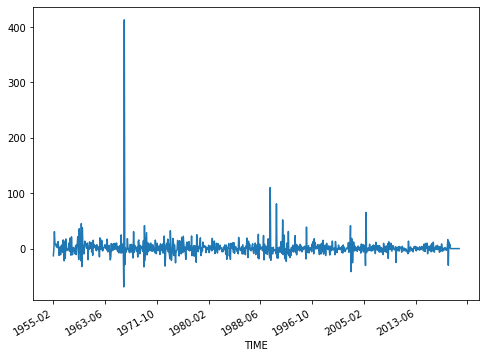

Single window of past history
[[-0.70386282]
 [-0.08499316]
 [ 1.39307225]
 [ 0.39347154]
 [ 0.29915694]
 [ 0.22537499]
 [ 0.07744298]
 [ 0.32368783]
 [ 0.01178203]
 [ 0.52837002]
 [ 0.11614562]
 [-0.66135731]
 [-0.02971884]
 [ 0.05917057]
 [-0.60907175]
 [ 0.08373073]
 [ 0.23904959]
 [-0.23791152]
 [-0.4036207 ]
 [ 0.67340167]]

 Target percentage change to predict
0.1846370943337145
[-7.03862815e-01 -8.49931570e-02  1.39307225e+00  3.93471538e-01
  2.99156936e-01  2.25374990e-01  7.74429774e-02  3.23687834e-01
  1.17820278e-02  5.28370022e-01  1.16145622e-01 -6.61357315e-01
 -2.97188383e-02  5.91705677e-02 -6.09071749e-01  8.37307318e-02
  2.39049586e-01 -2.37911516e-01 -4.03620696e-01  6.73401670e-01
  1.84637094e-01 -1.13764534e+00  5.67148374e-01 -9.32664324e-01
  7.57311482e-01 -8.72095128e-02 -2.49213039e-01 -1.18471364e-01
 -1.53504666e-01  2.40308367e-02  4.07431728e-01 -3.01606339e-01
  8.24742879e-01 -1.86216638e-01 -6.49126444e-01  9.38380376e-01
 -1.38670152e-01 -6.0623485

In [ ]:
#Defining the amount of data with which to train
TRAIN_SPLIT = 600 

tf.random.set_seed(13)

# Using just Italian data for our initial test
uni_data = carReg['ITA']
uni_data.index = carReg['TIME']
print(uni_data.head())

uni_data.plot(subplots=True)
plt.show()

uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data - uni_train_mean) / uni_train_std

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print('\n Target percentage change to predict')
print(y_train_uni[0])
print(uni_data)

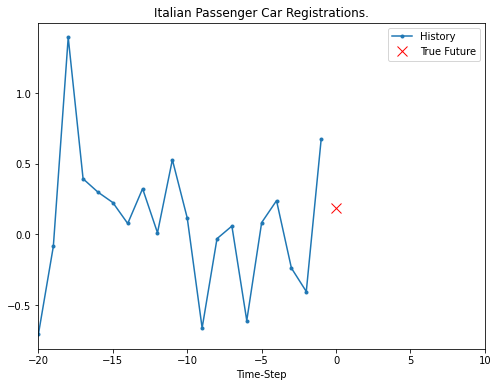

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel('Time-Step')
    plt.show()
    return plt


show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Italian Passenger Car Registrations.')

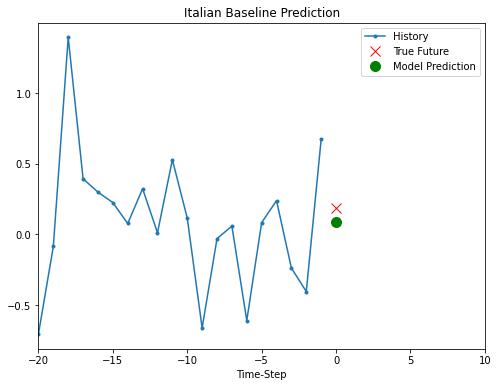

In [ ]:
# Baseline

def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 
          'Italian Baseline Prediction')
plt.show()


In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 759

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, activation='relu',return_sequences=True, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.LSTM(16, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(8, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
#troubleshootoing a traceback error

print(train_univariate)
print(val_univariate)

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>


(32, 1)
Epoch 1/10
759/759 [==============================] - 19s 25ms/step - loss: 0.4082 - val_loss: 0.2006
Epoch 2/10
759/759 [==============================] - 17s 23ms/step - loss: 0.3785 - val_loss: 0.1780
Epoch 3/10
759/759 [==============================] - 18s 23ms/step - loss: 0.3690 - val_loss: 0.1753
Epoch 4/10
759/759 [==============================] - 18s 24ms/step - loss: 0.3551 - val_loss: 0.1726
Epoch 5/10
759/759 [==============================] - 18s 23ms/step - loss: 0.3449 - val_loss: 0.1796
Epoch 6/10
759/759 [==============================] - 18s 23ms/step - loss: 0.3305 - val_loss: 0.1839
Epoch 7/10
759/759 [==============================] - 18s 23ms/step - loss: 0.3165 - val_loss: 0.1768
Epoch 8/10
759/759 [==============================] - 18s 23ms/step - loss: 0.2977 - val_loss: 0.1790
Epoch 9/10
759/759 [==============================] - 18s 23ms/step - loss: 0.2898 - val_loss: 0.1859
Epoch 10/10
759/759 [==============================] - 18s 23ms/step - los

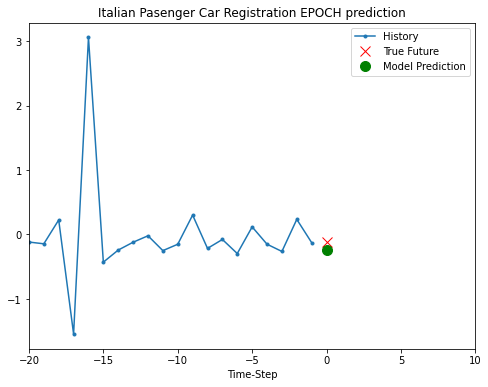

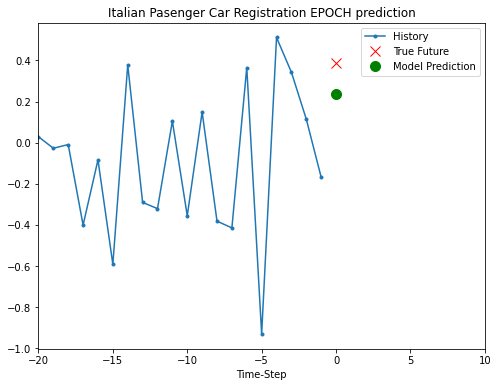

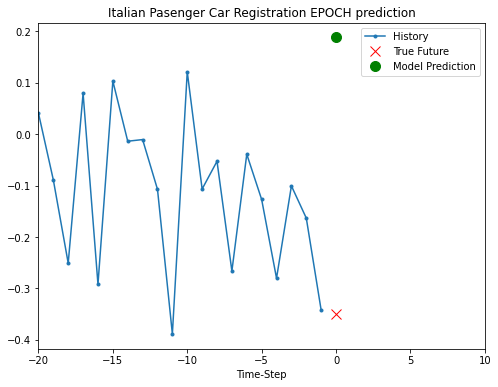

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

EVALUATION_INTERVAL = 759
EPOCHS = 20
EPOCHS2 = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS2, steps_per_epoch=EVALUATION_INTERVAL, 
                      validation_data=val_univariate, validation_steps=50) 
                      

for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Italian Pasenger Car Registration EPOCH prediction')

In [ ]:
# pulling in all eu countries from the dataset. EU27 called in first as it is the
# target to predict

features_considered = ['EU27','AUT','BEL','CZE','DEU','DNK','ESP','EST','FRA',
                       'GRC','HUN','IRL','ITA','LTU','LVA','NLD','POL','PRT','SVK','SVN','SWE']

features = carReg[features_considered]
features.index = carReg['TIME']
features.head()

,EU27,AUT,BEL,CZE,DEU,DNK,ESP,EST,FRA,GRC,HUN,IRL,ITA,LTU,LVA,NLD,POL,PRT,SVK,SVN,SWE
TIME,,,,,,,,,,,,,,,,,,,,,
1955-02,0.0,0.0,16.521049,0.0,-8.020994,-12.221476,0.0,0.0,0.0,0.0,0.0,0.0,-13.027451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1955-03,0.0,0.0,-9.421857,0.0,-9.979883,-17.767708,0.0,0.0,0.0,0.0,0.0,0.0,-0.138196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1955-04,0.0,0.0,4.746142,0.0,19.943288,-10.998108,0.0,0.0,0.0,0.0,0.0,0.0,30.645605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1955-05,0.0,0.0,43.642685,0.0,10.894592,4.146703,0.0,0.0,0.0,0.0,0.0,0.0,9.826831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1955-06,0.0,0.0,-13.099245,0.0,-6.176003,-23.737382,0.0,0.0,0.0,0.0,0.0,0.0,7.862532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f044f6f4828>,
      dtype=object)

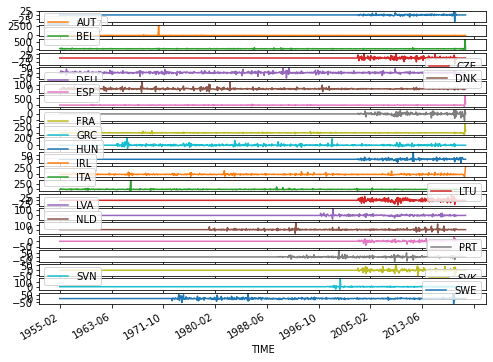

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)


dataset = (dataset-data_mean)/data_std

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


In [ ]:
dataset[:5,:]

array([[-1.99326082e-02, -5.50894873e-02,  1.40873819e+00,
        -2.38702925e-02, -9.45675221e-01, -6.75908910e-01,
        -1.12297359e-01, -3.35062760e-02, -6.52765679e-02,
        -1.20637473e-01, -5.05692966e-03, -1.18294611e-01,
        -7.03862815e-01, -4.99852942e-02, -7.14368656e-02,
        -5.17293890e-02, -2.09990453e-03, -2.79786570e-02,
        -2.47227411e-02, -3.92532377e-02, -4.57393632e-02],
       [-1.99326082e-02, -5.50894873e-02, -9.39240401e-01,
        -2.38702925e-02, -1.15550287e+00, -9.29777281e-01,
        -1.12297359e-01, -3.35062760e-02, -6.52765679e-02,
        -1.20637473e-01, -5.05692966e-03, -1.18294611e-01,
        -8.49931570e-02, -4.99852942e-02, -7.14368656e-02,
        -5.17293890e-02, -2.09990453e-03, -2.79786570e-02,
        -2.47227411e-02, -3.92532377e-02, -4.57393632e-02],
       [-1.99326082e-02, -5.50894873e-02,  3.43043001e-01,
        -2.38702925e-02,  2.04973713e+00, -6.19911552e-01,
        -1.12297359e-01, -3.35062760e-02, -6.52765679e

In [ ]:
past_history = 200
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)


In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (50, 21)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()


single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')


In [ ]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(32, 1)


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS2,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)


Epoch 1/10
759/759 [==============================] - 17s 22ms/step - loss: 0.1264 - val_loss: 0.2158
Epoch 2/10
759/759 [==============================] - 17s 23ms/step - loss: 0.1019 - val_loss: 0.2276
Epoch 3/10
759/759 [==============================] - 16s 21ms/step - loss: 0.0889 - val_loss: 0.2209
Epoch 4/10
759/759 [==============================] - 16s 21ms/step - loss: 0.0787 - val_loss: 0.2212
Epoch 5/10
759/759 [==============================] - 16s 21ms/step - loss: 0.0712 - val_loss: 0.2202
Epoch 6/10
759/759 [==============================] - 16s 21ms/step - loss: 0.0644 - val_loss: 0.2141
Epoch 7/10
759/759 [==============================] - 16s 21ms/step - loss: 0.0615 - val_loss: 0.2102
Epoch 8/10
759/759 [==============================] - 18s 24ms/step - loss: 0.0593 - val_loss: 0.1986
Epoch 9/10
759/759 [==============================] - 16s 21ms/step - loss: 0.0585 - val_loss: 0.2014
Epoch 10/10
759/759 [==============================] - 16s 21ms/step - loss: 0.055

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()


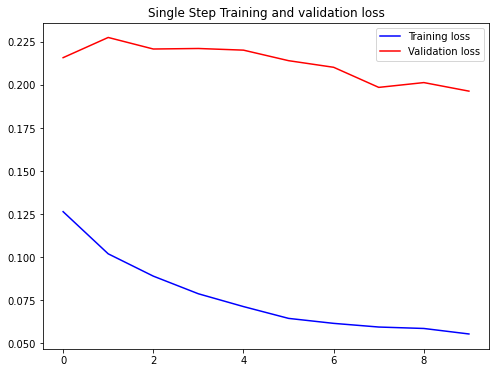

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')


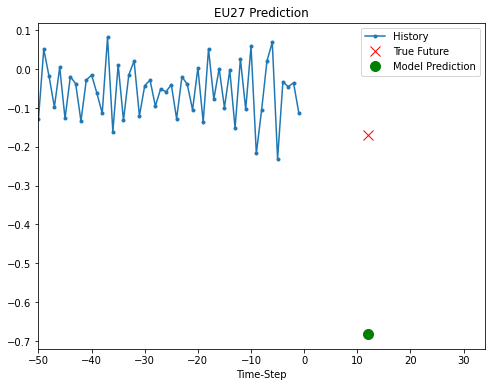

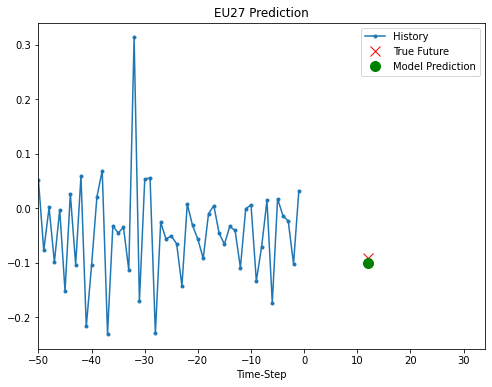

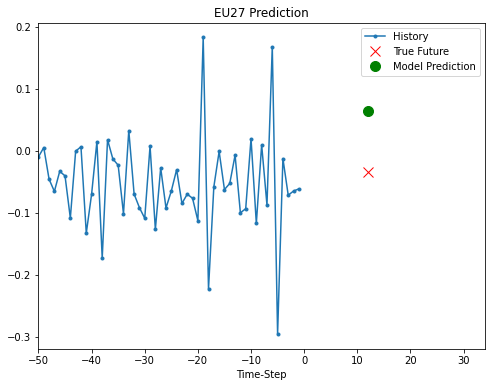

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'EU27 Prediction')
  plot.show()

In [ ]:
future_target = 10
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target percentage change to predict : {}'.format(y_train_multi[0].shape))


Single window of past history : (50, 21)

 Target percentage change to predict : (10,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


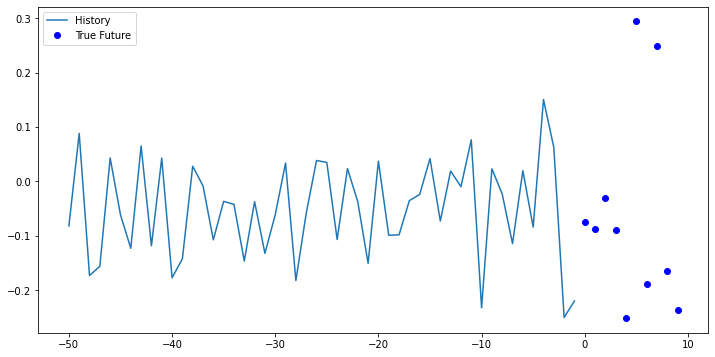

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))


In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(10))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


(32, 10)


In [ ]:
EPOCHS3 = 20

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS3,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)


Epoch 1/20
759/759 [==============================] - 30s 40ms/step - loss: 0.1352 - val_loss: 0.0881
Epoch 2/20
759/759 [==============================] - 30s 39ms/step - loss: 0.1312 - val_loss: 0.0942
Epoch 3/20
759/759 [==============================] - 30s 40ms/step - loss: 0.1278 - val_loss: 0.0972
Epoch 4/20
759/759 [==============================] - 30s 39ms/step - loss: 0.1230 - val_loss: 0.1007
Epoch 5/20
759/759 [==============================] - 30s 40ms/step - loss: 0.1179 - val_loss: 0.1048
Epoch 6/20
759/759 [==============================] - 32s 42ms/step - loss: 0.1112 - val_loss: 0.1074
Epoch 7/20
759/759 [==============================] - 30s 39ms/step - loss: 0.1043 - val_loss: 0.1121
Epoch 8/20
759/759 [==============================] - 30s 39ms/step - loss: 0.0991 - val_loss: 0.1133
Epoch 9/20
759/759 [==============================] - 31s 41ms/step - loss: 0.0946 - val_loss: 0.1139
Epoch 10/20
759/759 [==============================] - 30s 39ms/step - loss: 0.090

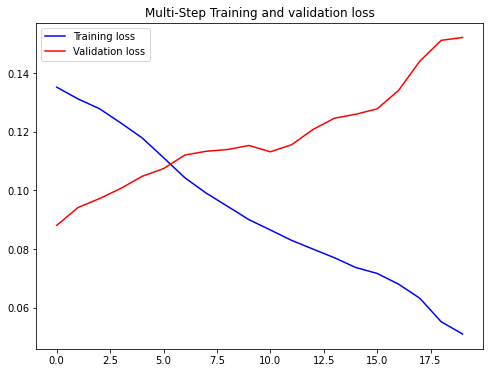

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


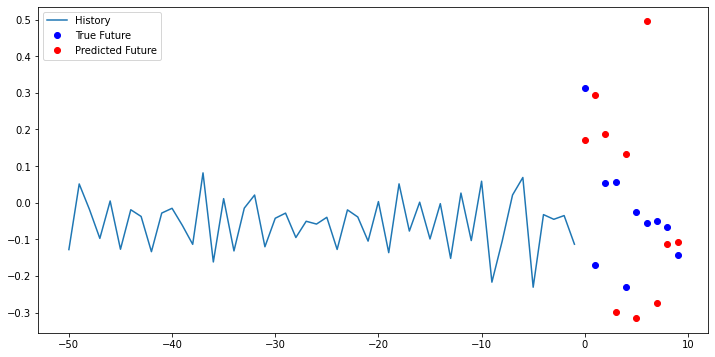

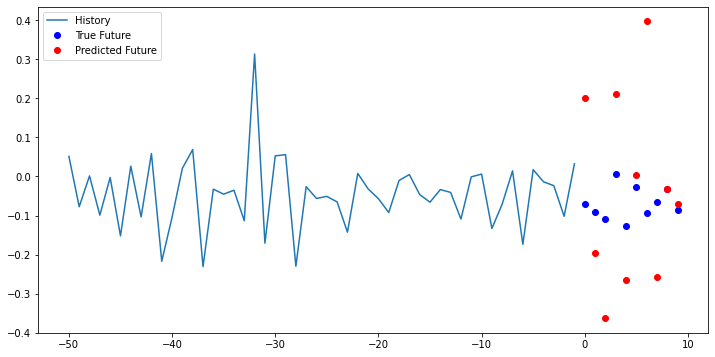

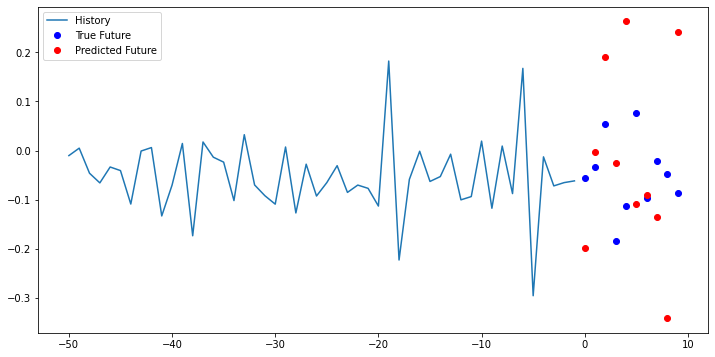

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
